#### This is a testing notebook to run some cleaning of the current database

In [2]:
import requests
import pandas as pd
import numpy as np
import json
import datetime
import quandl

In [31]:
import matplotlib.pyplot as plt

In [33]:
% matplotlib inline

In [42]:
import sqlite3

In [45]:
sqlite_file = 'securities_master_db.sqlite'

In [3]:
# Copied in the relevant functions from database creation

def create_df_crypto(symbol, curr='USD', limit=2500):
    ''' This function takes in a symbol of a cryptocurrency to be
        used with the Cryptocompare API, and returns a formatted dataframe
        for later processing.

        Args: symbol - cryptocurrency symbol
              curr - currency to report in (default USD)
              limit - max number of data points (default 2500)

        Return: df - dataframe of daily price info for symbol
    '''
    # Set url and params for the call to Cryptocompare API
    url = 'https://min-api.cryptocompare.com/data/histoday'
    params = {'fsym': symbol, 'tsym': curr, 'limit': limit}

    # Call API for symbol and put data into pandas dataframe
    response = requests.get(url, params=params)
    data = response.json()['Data']
    df = pd.DataFrame(data)

    # Add date column and set to index
    df['Date'] =[datetime.date.fromtimestamp(d) for d in df.time]
    df = df[['open', 'high', 'low', 'close', 'volumeto', 'Date']]
    df.set_index('Date', inplace=True)

    # Rename volumeto column
    df.rename(columns={'volumeto': 'volume'}, inplace=True)

    return df

def create_df_quandl(symbol, api_key):
    ''' This function takes in a symbol of a futures contract to be used
        with the Quandl API as well as the API key, and returns a formatted
        dataframe for processing.

        Args: symbol - a symbol for a continuous futures contract
              api_key - Quandl API key

        Return: df - dataframe for daily price info for symbol
    '''
    # Quandl API call which puts price data into dataframe
    df = quandl.get('SCF/CME_{s}1_FW'.format(s=symbol), authtoken=api_key)

    # Drop open interest column and rename Settle column
    df.drop(['Prev. Day Open Interest'], axis=1, inplace=True)
    df.rename(columns={'Open': 'open',
                      'High': 'high',
                      'Low': 'low',
                      'Settle': 'close',
                      'Volume': 'volume'}, inplace=True)
    return df

def generate_df_dict(product_dict, api_key=None):
    ''' This function takes in a dict of product symbols mapped to
        information about the product  and a Quandl API key and returns
        a dict object with the symbols as keys and a dataframe of price
        info as values.

        Args: product_dict - a dict of symbols for products with maps to
                             a list of info
              api_key - Quandl API key

        Return: df_dict - a dictionary of symbols mapped to dataframes
                          of price info
    '''
    df_dict = {}

    # Iterate through list
    for product, info in product_dict.items():
        # Determine what dataframe creator to use
        if info[0] == 1:
            df = create_df_crypto(product)
        if info[0] == 2:
            df = create_df_quandl(product, api_key)

        df_dict[product] = df

    return df_dict

In [6]:
# Setting up the products, database and api key
# Sqlite3 db info and Quandl key
sqlite_file = 'securities_master_db.sqlite'
api_key = 'Hv95pPh1xQWzt5DFhxS7'

# Dict of all products with maps to data_id, name, sector, and exchange
products = {'CL': [2, 'Crude', 'Energy', 'CME'],
                'HO': [2, 'HeatOil', 'Energy', 'CME'],
                'NG': [2, 'NatGas', 'Energy', 'CME'],
                'GC': [2, 'Gold', 'Metals', 'CME'],
                'SI': [2, 'Silver', 'Metals', 'CME'],
                'AD': [2, 'Aussie', 'Forex', 'CME'],
                'CD': [2, 'Canadien', 'Forex', 'CME'],
                'EC': [2, 'Euro', 'Forex', 'CME'],
                'BP': [2, 'Pound', 'Forex', 'CME'],
                'JY': [2, 'Yen', 'Forex', 'CME'],
                'US': [2, '30-yr', 'Treasuries', 'CME'],
                'C': [2, 'Corn', 'Grains', 'CME'],
                'W': [2, 'Wheat', 'Grains', 'CME'],
                'S': [2, 'Soybeans', 'Grains', 'CME'],
                'ES': [2, 'E-mini', 'Indexes', 'CME'],
                'BTC': [1, 'Bitcoin', 'Cryptocurrency', 'CCAgg'],
                'ETH': [1, 'Ethereum', 'Cryptocurrency', 'CCAgg'],
                'XRP': [1, 'Ripple', 'Cryptocurrency', 'CCAgg'],
                'BCH': [1, 'BitcoinCash', 'Cryptocurrency', 'CCAgg'],
                'LTC': [1, 'Litecoin', 'Cryptocurrency', 'CCAgg'],
                'ADA': [1, 'Cardano', 'Cryptocurrency', 'CCAgg'],
                'NEO': [1, 'Neo', 'Cryptocurrency', 'CCAgg'],
                'XLM': [1, 'Stellar', 'Cryptocurrency', 'CCAgg'],
                'EOS': [1, 'EOS', 'Cryptocurrency', 'CCAgg'],
                'XMR': [1, 'Monero', 'Cryptocurrency', 'CCAgg'],}

In [8]:
# Create a dict for cryptocurrencies only as these will need to have 0 data deleted
crypto_dict = {prod: info for prod, info in products.items() if info[0] == 1}

In [10]:
df_dict_crypto = generate_df_dict(crypto_dict)

In [11]:
eth = df_dict_crypto['ETH']
eth.head()

,open,high,low,close,volume
Date,,,,,
2012-09-28,0.0,0.0,0.0,0.0,0.0
2012-09-29,0.0,0.0,0.0,0.0,0.0
2012-09-30,0.0,0.0,0.0,0.0,0.0
2012-10-01,0.0,0.0,0.0,0.0,0.0
2012-10-02,0.0,0.0,0.0,0.0,0.0


In [27]:
eth_vol = eth[eth.volume > 1000000.0]
start_date = eth.index[eth.volume > 1000000.0].tolist()[0]
start_date

datetime.date(2016, 3, 4)

In [25]:
eth_vol.head()

,open,high,low,close,volume
Date,,,,,
2016-03-04,9.96,12.00,9.75,11.00,1726260.37
2016-03-11,11.25,13.48,11.03,13.25,1669862.35
2016-03-12,13.25,15.18,12.00,15.00,1539173.65
2016-03-13,15.00,15.00,10.50,12.50,1909296.28
2016-03-16,12.92,13.00,10.20,11.14,1442272.97


In [28]:
eth_mil_vol = eth[start_date:]
eth_mil_vol.head()

,open,high,low,close,volume
Date,,,,,
2016-03-04,9.96,12.00,9.75,11.00,1726260.37
2016-03-05,11.00,11.90,9.75,10.98,845841.96
2016-03-06,10.98,11.47,9.06,9.50,732233.35
2016-03-07,9.50,10.89,8.49,9.88,592001.58
2016-03-08,9.88,12.00,9.60,11.55,568223.02


In [29]:
eth_mil_vol.describe()

,open,high,low,close,volume
count,748.000000,748.000000,748.000000,748.000000,7.480000e+02
mean,210.007045,220.404813,197.495668,210.707968,1.378052e+08
std,298.505673,313.713006,279.228463,298.652208,2.509914e+08
min,6.690000,7.300000,5.970000,6.690000,1.095651e+05
25%,11.210000,11.592500,10.857500,11.210000,1.290058e+06
50%,25.880000,30.460000,25.105000,28.515000,1.357504e+07
75%,303.217500,311.247500,292.415000,303.655000,1.805907e+08
max,1385.020000,1422.860000,1271.070000,1385.020000,2.034011e+09


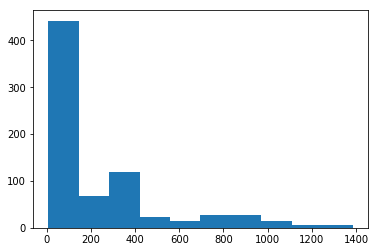

In [36]:
plt.hist(eth_mil_vol.close)
plt.show()

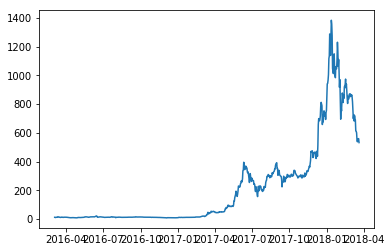

In [37]:
plt.plot(eth_mil_vol.index, eth_mil_vol.close)
plt.show()

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  """Entry point for launching an IPython kernel.


{'boxes': [<matplotlib.lines.Line2D at 0x110970fd0>],
 'caps': [<matplotlib.lines.Line2D at 0x11097a3c8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1109856a0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1109852b0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11097a048>,
  <matplotlib.lines.Line2D at 0x11097a588>]}

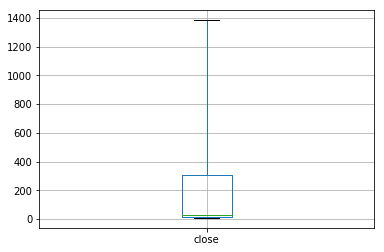

In [41]:
eth_mil_vol.boxplot(column='close', whis='range')

In [47]:
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

c.execute("SELECT * FROM Symbols LIMIT 5")
c.fetchall()

OperationalError: no such table: Symbols

In [48]:
conn.close()